# Автоматическое определение жанра по словам песни

In [0]:
import sqlite3
import pickle
import os

In [0]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import quote
import re

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#check if file exists
!ls  drive/My\ Drive/Colab\ Notebooks/lyrics.db

'drive/My Drive/Colab Notebooks/lyrics.db'


Создадим собственную базу данных для собранного корпуса песен с помощью библиотеки sqlite.

In [0]:
con = sqlite3.connect('drive/My Drive/Colab Notebooks/lyrics.db')

Заполняем её двумя таблицами с жанрами и словами песен.

In [0]:
#run once for new database
sql_create_genres_table= '''CREATE TABLE IF NOT EXISTS genres (
                                genre text PRIMARY KEY,
                                href text NOT NULL,
                                page_count integer NOT NULL
                            );'''
sql_create_lyrics_table= '''CREATE TABLE IF NOT EXISTS lyrics (
                                title text PRIMARY KEY,
                                genre text,
                                lyrics text,
                                FOREIGN KEY (genre) REFERENCES genres (genre)
                            );'''
con.execute(sql_create_genres_table)
con.execute(sql_create_lyrics_table)

In [0]:
#add new column to existing table
con.execute('ALTER TABLE lyrics ADD href text;')


Соберём все жанры с сайта lyrics.com и вставим их в таблицу с жанрами.

In [0]:
#fetch genres from lyrics.com
doc = BeautifulSoup(urlopen(r"https://www.lyrics.com/genre/Blues"))

genres = [(item.text,quote(item['data-link'].replace('/genre/','').replace('Blues;', ''))) for item in doc('button', attrs={'class': "action btn xsml", 'data-tag': "genre"})]
doc= None
con.execute('INSERT INTO genres (genre, href, page_count) values (?, ?, ?);', ('Blues', 'Blues', 0))
for genre, href in genres:
  con.execute('INSERT INTO genres (genre, href, page_count) values (?, ?, ?);', (genre, href, 0))


Посчитаем количество страниц для каждого жанра.

In [0]:
#query number of pages from lyrics.com for all genres
cur = con.execute('SELECT genre, href FROM genres')
page_counts = {}
for genre, href in cur.fetchall():
  doc = BeautifulSoup(urlopen(r'https://www.lyrics.com/genre/'+href))
  page_counts[genre] = 0
  try:
    page_counts[genre] = max([int(item.text) for item in doc('a', attrs={'class' : 'rc5'})])
  except:
    pass
for genre in page_counts:
  con.execute('UPDATE genres SET page_count=? WHERE genre=?', (page_counts[genre], genre))

Вот такие жанры у нас получились.

In [0]:
#show genres information
cur = con.execute('SELECT * FROM genres')
cur.fetchall()

[('Blues', 'Blues', 336),
 ('Brass & Military', 'Brass%20__%20Military', 2),
 ("Children's", 'Children%27s', 17),
 ('Classical', 'Classical', 47),
 ('Electronic', 'Electronic', 1352),
 ('Folk, World, & Country', 'Folk%2C%20World%2C%20__%20Country', 1243),
 ('Funk / Soul', 'Funk%20--%20Soul', 824),
 ('Hip Hop', 'Hip%20Hop', 823),
 ('Jazz', 'Jazz', 860),
 ('Latin', 'Latin', 437),
 ('Non-Music', 'Non-Music', 30),
 ('Pop', 'Pop', 2940),
 ('Reggae', 'Reggae', 184),
 ('Rock', 'Rock', 5144),
 ('Spiritual', 'Spiritual', 0),
 ('Stage & Screen', 'Stage%20__%20Screen', 153)]

Теперь заполним таблицу со словами песен.

In [0]:
con.execute('DELETE FROM lyrics')
for item in os.listdir('drive/My Drive/Colab Notebooks/'):
    if item[-12:] == '_content.pkl':
        cur = con.execute('SELECT genre FROM genres WHERE href=?', (item[:-12], ))
        genre = cur.fetchone()[0]
        print(item, genre)
        content = pickle.load(open('drive/My Drive/Colab Notebooks/'+item, 'rb'))
        for title in content.keys():
            try:
                con.execute('INSERT INTO lyrics (title, genre, lyrics) VALUES (?, ?, ?);', (title, genre, content[title]))
            except:
                print(title, 'error')

Blues_content.pkl Blues
Classical_content.pkl Classical
Children%27s_content.pkl Children's
Brass%20__%20Military_content.pkl Brass & Military
Electronic_content.pkl Electronic
Folk%2C%20World%2C%20__%20Country_content.pkl Folk, World, & Country
Stage%20__%20Screen_content.pkl Stage & Screen
Reggae_content.pkl Reggae
Latin_content.pkl Latin
Non-Music_content.pkl Non-Music
Jazz_content.pkl Jazz


Добавим песни жанра "рок".

In [0]:
import gzip
with gzip.open('drive/My Drive/Colab Notebooks/Rock.pkl.gz', 'rb') as f:
    content = pickle.load(f)
    
genre = 'Rock'
print(genre)
for title in content.keys():
    try:
        con.execute('INSERT INTO lyrics (title, genre, lyrics) VALUES (?, ?, ?);', (title, genre, content[title]))
    except:
        print(title, 'error')

Посмотрим количество песен.

In [0]:
con.execute('SELECT count(*) FROM lyrics WHERE lyrics NOT NULL').fetchone()

(97686,)

Столько песен приходится на каждый жанр.

In [0]:
data = con.execute('SELECT genre, count(*) FROM lyrics WHERE lyrics not NULL GROUP BY genre').fetchall()
data

[('Blues', 3636),
 ('Brass & Military', 16),
 ("Children's", 215),
 ('Classical', 486),
 ('Electronic', 16992),
 ('Folk, World, & Country', 14064),
 ('Jazz', 5659),
 ('Latin', 4950),
 ('Non-Music', 304),
 ('Reggae', 2067),
 ('Rock', 47547),
 ('Stage & Screen', 1750)]

Отобразим данные.

In [0]:
import seaborn as sns
import pandas as pd

data = con.execute('SELECT genre FROM lyrics WHERE lyrics not NULL').fetchall()

df = pd.DataFrame(data, columns=('Genre',))
df.head()

Genre
0  Blues
1  Blues
2  Blues
3  Blues
4  Blues

[Text(0, 0, 'Blues'),
 Text(0, 0, 'Classical'),
 Text(0, 0, "Children's"),
 Text(0, 0, 'Brass & Military'),
 Text(0, 0, 'Electronic'),
 Text(0, 0, 'Folk, World, & Country'),
 Text(0, 0, 'Stage & Screen'),
 Text(0, 0, 'Reggae'),
 Text(0, 0, 'Latin'),
 Text(0, 0, 'Non-Music'),
 Text(0, 0, 'Jazz'),
 Text(0, 0, 'Rock')]

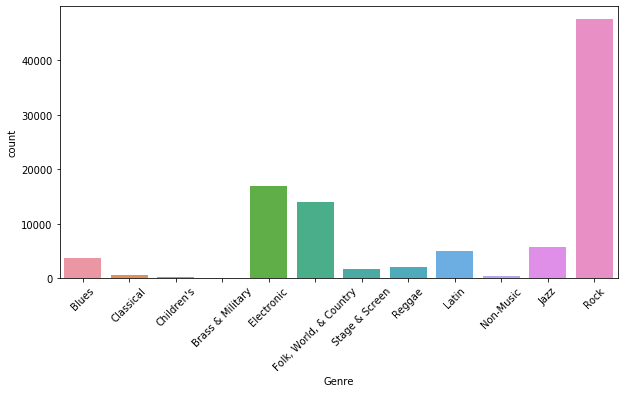

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
chart = sns.countplot(x='Genre', data=df,orient='v')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Как видно, данные сильно не сбалансированны. Исключим из рассмотрения жанры, которые представлены малым количеством примеров (менее 1000).

In [0]:
import seaborn as sns
import pandas as pd

data = con.execute('SELECT genre FROM lyrics WHERE genre IN (SELECT genre FROM lyrics GROUP BY genre HAVING count(*)>1000)').fetchall()

df = pd.DataFrame(data, columns=('Genre',))

[Text(0, 0, 'Blues'),
 Text(0, 0, 'Electronic'),
 Text(0, 0, 'Folk, World, & Country'),
 Text(0, 0, 'Stage & Screen'),
 Text(0, 0, 'Reggae'),
 Text(0, 0, 'Latin'),
 Text(0, 0, 'Jazz'),
 Text(0, 0, 'Rock')]

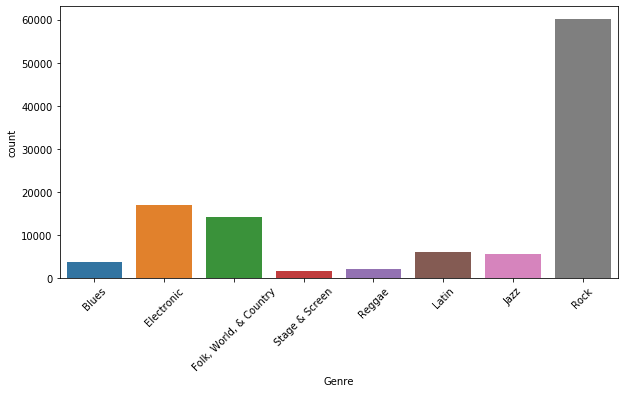

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
chart = sns.countplot(x='Genre', data=df,orient='v')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Данные по-прежнему сильно не равномерны. Поэтому из жанров будем брать случайную выборку по 10000 примеров.

In [5]:
genres = [item[0] for item in con.execute('SELECT genre FROM lyrics GROUP BY genre HAVING count(*)>1000').fetchall()]
genres

['Blues',
 'Electronic',
 'Folk, World, & Country',
 'Jazz',
 'Latin',
 'Reggae',
 'Rock',
 'Stage & Screen']

In [12]:
import random
import numpy as np

X_train = []
X_test = []
Y_train = []
Y_test = []
for genre in genres:
    lyrics = [item[0] for item in con.execute('SELECT lyrics FROM lyrics WHERE lyrics NOT NULL AND genre=?', (genre,)).fetchall()]
    lyrics_shuff = np.arange(len(lyrics))
    np.random.shuffle(lyrics_shuff)
    lyrics_train = list(lyrics_shuff[int(len(lyrics)*0.3):])
    lyrics_test = list(lyrics_shuff[:int(len(lyrics)*0.3)])

    lyr_temp = []
    lyr_size = 7000
    if len(lyrics_train) < lyr_size:
        n = lyr_size//len(lyrics_train)
        for i in range(n):
            lyr_temp += lyrics_train
    while len(lyr_temp) < lyr_size:
        lyr_temp.append(lyrics_train[random.randint(0,len(lyrics_train)-1)])
    for i in lyr_temp:
        X_train.append(lyrics[i])
    for i in range(lyr_size):
        Y_train.append(genre)

    lyr_temp = []
    lyr_size = 3000
    if len(lyrics_test) < lyr_size:
        n = lyr_size//len(lyrics_test)
        for i in range(n):
            lyr_temp += lyrics_test
    while len(lyr_temp) < lyr_size:
        lyr_temp.append(lyrics_test[random.randint(0,len(lyrics_test)-1)])
    for i in lyr_temp:
        X_test.append(lyrics[i])
    for i in range(lyr_size):
        Y_test.append(genre)
print(len(X_train), len(X_test), len(Y_train), len(Y_test))

56000 24000 56000 24000


Сохраним базу и закроем её.

In [0]:
#save changes and close database
con.commit()
con.close()

In [3]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Произведём предобработку текста песен, а именно токенизацию и лемматизацию, с помощью предобученной модели spacy.

In [0]:
import spacy
import en_core_web_md # Загрузка предобученной модели английского языка

In [0]:
nlp = en_core_web_md.load()

Произведём векторизацию слов песен с помощью предобученной модели word2vec.

In [86]:
import gensim.downloader as api
model = api.load('glove-twitter-100')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
X = X_train + X_test
Y = Y_train + Y_test

В результате первичной обработки текста мы получили два списка: первый - список токенизированных песен, второй - соответствующий им список жанров. Сохраним их в pickle файлы.

In [19]:
from tqdm import tqdm_notebook
X_tok = []
X_max_len = 0
for i in tqdm_notebook(range(len(X))):
    X_lemmas = []
    for one_token in nlp(X[i].strip().lower()):
        if one_token.lemma_ in model:
            X_lemmas.append(one_token.lemma_)
    X_tok.append(X_lemmas)
    if len(X_lemmas) > X_max_len:
        X_max_len = len(X_lemmas)
print(X_tok[0], X_max_len)


['down', 'here', 'the', 'river', ',', 'meet', 'the', 'sea', 'and', 'in', 'the', 'sticky', 'heat', 'i', 'feel', 'ya', "'", 'open', 'up', 'to', 'love', 'come', 'out', 'of', 'nowhere', 'baby', ',', 'just', 'like', 'a', 'hurricane', 'and', 'feel', 'like', 'rain', 'and', 'feel', 'like', 'rain', 'lie', 'here', ',', 'underneath', 'the', 'star', 'right', 'next', 'to', 'and', 'be', 'wonder', 'who', 'be', 'and', 'how', 'do', 'do', '?', 'how', 'do', 'do', ',', 'baby', '?', 'the', 'cloud', 'roll', 'in', 'across', 'the', 'moon', 'and', 'the', 'wind', 'howl', 'out', 'name', 'and', 'feel', 'like', 'rain', 'and', 'feel', 'like', 'rain', 'never', 'go', 'to', 'make', 'that', 'bridge', 'tonight', 'baby', 'across', 'lake', 'and', 'feel', 'like', 'rain', 'and', 'feel', 'like', 'rain', 'so', 'batten', 'down', 'the', 'hatch', 'baby', 'and', 'leave', 'heart', 'up', 'sleeve', 'look', 'like', 'be', 'in', 'for', 'stormy', 'weather', ',', 'that', 'be', 'not', 'no', 'cause', 'for', 'to', 'leave', 'just', 'lie', '

In [0]:
'''
with open('drive/My Drive/Colab Notebooks/Lyrics_X_tok_56000_24000.pkl', 'wb') as f:
    pickle.dump(X_tok, f)

with open('drive/My Drive/Colab Notebooks/Lyrics_Y_56000_24000.pkl', 'wb') as f:
    pickle.dump(Y, f)
'''

In [0]:
with open('drive/My Drive/Colab Notebooks/Lyrics_X_tok_56000_24000.pkl', 'rb') as f:
    X_tok = pickle.load(f)

with open('drive/My Drive/Colab Notebooks/Lyrics_Y_56000_24000.pkl', 'rb') as f:
    Y = pickle.load(f)

In [88]:
import numpy as np
X_len = [len(item) for item in X_tok]
X_len_median = np.median(X_len)
X_len_mean = np.mean(X_len)
print(X_len_median, X_len_mean)

191.0 219.45665


Длина самой длиной песни оказалась 2800 токенов, однако в целях сохранения памяти, максимальная длина последовательности была выбрана по среднему значению:

In [0]:
X_max_len = 220

Закодируем названия жанров в виде чисел и представим их в виде one-hot векторов.

In [0]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import numpy as np
y_le = preprocessing.LabelEncoder()
y_le.fit(Y)
y_1 = y_le.transform(Y)
one_hot_y = to_categorical(y_1)

Разобьём данные на тренировочную, тестовую и валидационную выборки.

In [0]:
from sklearn.model_selection import train_test_split

train_x = X_tok[:56000]
another_x = X_tok[56000:]

train_y = one_hot_y[:56000]
another_y = one_hot_y[56000:]

val_x, test_x, val_y, test_y = train_test_split(another_x, another_y, train_size = 0.5, shuffle=True)

In [0]:
'''
from sklearn.model_selection import train_test_split
train_x, second_x, train_y, second_y = train_test_split(X_tok, one_hot_y, train_size = 0.6, shuffle=True)
val_x, test_x, val_y, test_y = train_test_split(second_x, second_y, train_size = 0.5)
'''

Тренировочную выборку отдадим на вход генератору (о нем чуть ниже), а из валидационной сделаем трёхмерную матрицу (кол-во примеров, максимальная длина последовательности = 220, длина вектора из предобученной модели word2vec).

In [0]:
def to_matrix(data, max_len, model):
    M = np.zeros((len(data), max_len, model.vector_size))
    for i in range(len(data)):
        for j in range(min(max_len, len(data[i]))):
            M[i][j] = model.get_vector(data[i][j])
    return M

In [0]:
x_val = to_matrix(val_x, X_max_len, model)

Напишем генератор, который формирует векторное представление очередного пакета данных из токенизированной обучающей выборки.

In [0]:
import tensorflow as tf
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,  
                 batch_size,       # Размер батча
                 embedding_dim,    # Размер эмбеддинга
                 max_length,       # Максимальная длина предложения
                 input_X,          # Входные данные (списки токенов)
                 input_Y,          # Ответы в виде one-hot векторов
                 model,            # Модель векторного представления
                 shuffle=True      # Надо ли перемешивать
                 ):        

        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.X = input_X
        self.Y = input_Y
        self.model = model

        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)       
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
                
        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Создается тензор с объектами
        # Размерность: BATCH_SIZE x MAX_LENGTH x EMBEDDING_DIM
        X = np.zeros(shape=(self.batch_size, 
                            self.max_length, 
                            self.embedding_dim)) 
        y = np.zeros((self.batch_size, self.Y.shape[1]), dtype=int)
        # Generate data
        for instance_number in range(self.batch_size):
            Xi = np.zeros(shape=(self.max_length, self.embedding_dim))
            for i in range(min(self.max_length, len(self.X[indexes[instance_number]]))): # идем по номерам слов в одном примере
                word = self.X[indexes[instance_number]][i] # одно слово из примера
                Xi[i,:] = self.model[word] # матрица из одного примера
            X[instance_number,:,:] = Xi # в матрицу батча записываем один пример
            y[instance_number,:] = self.Y[indexes[instance_number],:]
        return X, y

In [0]:
X_gen = DataGenerator(128, model.vector_size, X_max_len, train_x, train_y, model, shuffle=True)

Решим задачу классификации, используя модель свёрточной нейронной сети.

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

def CNNModel(
    maxlen, # Максимальная длина последовательности
    embedding_dim, # Разбер эмбеддинга
    class_number,
    filters = 32,
    neurons = 64
):

  inputs = layers.Input(shape=(maxlen, embedding_dim))
  convs = []
  for kernel_size in [2,3,4,5]:
    c = layers.Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    c = layers.GlobalMaxPool1D()(c)
    convs.append(c)
  x = layers.Concatenate()(convs)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(neurons, activation = 'tanh')(x)
  x = layers.Dropout(0.3)(x)
  output = layers.Dense(class_number, 
                 activation = 'softmax'
                 )(x)
  model = models.Model(inputs = inputs, outputs = output)
  return model

In [0]:
modelCNN = CNNModel(X_max_len, model.vector_size, len(y_le.classes_))
modelCNN.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
history = modelCNN.fit_generator(X_gen, epochs=20, validation_data=(x_val, val_y))

Epoch 1/20
437/437 [==============================] - 26s 60ms/step - loss: 1.7819 - acc: 0.3355 - val_loss: 1.5942 - val_acc: 0.4170
Epoch 2/20
437/437 [==============================] - 25s 57ms/step - loss: 1.4921 - acc: 0.4587 - val_loss: 1.5772 - val_acc: 0.4257
Epoch 3/20
437/437 [==============================] - 25s 57ms/step - loss: 1.3346 - acc: 0.5222 - val_loss: 1.6151 - val_acc: 0.4282
Epoch 4/20
437/437 [==============================] - 25s 57ms/step - loss: 1.2211 - acc: 0.5645 - val_loss: 1.6289 - val_acc: 0.4421
Epoch 5/20
437/437 [==============================] - 25s 57ms/step - loss: 1.1392 - acc: 0.5972 - val_loss: 1.7764 - val_acc: 0.4449
Epoch 6/20
437/437 [==============================] - 25s 57ms/step - loss: 1.0833 - acc: 0.6148 - val_loss: 1.8236 - val_acc: 0.4351
Epoch 7/20
437/437 [==============================] - 25s 57ms/step - loss: 1.0448 - acc: 0.6288 - val_loss: 1.8226 - val_acc: 0.4470
Epoch 8/20
437/437 [==============================] - 25s 58ms

In [99]:
history = modelCNN.fit_generator(X_gen, epochs=20, validation_data=(x_val, val_y))

Epoch 1/20
437/437 [==============================] - 25s 57ms/step - loss: 0.7940 - acc: 0.7222 - val_loss: 2.1668 - val_acc: 0.4309
Epoch 2/20
437/437 [==============================] - 25s 56ms/step - loss: 0.7777 - acc: 0.7266 - val_loss: 2.1695 - val_acc: 0.4349
Epoch 3/20
437/437 [==============================] - 25s 57ms/step - loss: 0.7718 - acc: 0.7283 - val_loss: 2.2120 - val_acc: 0.4382
Epoch 4/20
437/437 [==============================] - 25s 56ms/step - loss: 0.7655 - acc: 0.7333 - val_loss: 2.2128 - val_acc: 0.4408
Epoch 5/20
437/437 [==============================] - 25s 57ms/step - loss: 0.7607 - acc: 0.7326 - val_loss: 2.1733 - val_acc: 0.4387
Epoch 6/20
437/437 [==============================] - 25s 56ms/step - loss: 0.7501 - acc: 0.7400 - val_loss: 2.2451 - val_acc: 0.4338
Epoch 7/20
437/437 [==============================] - 24s 56ms/step - loss: 0.7450 - acc: 0.7373 - val_loss: 2.2090 - val_acc: 0.4380
Epoch 8/20
437/437 [==============================] - 25s 57ms

In [100]:
history = modelCNN.fit_generator(X_gen, epochs=20, validation_data=(x_val, val_y))

Epoch 1/20
437/437 [==============================] - 25s 58ms/step - loss: 0.6744 - acc: 0.7630 - val_loss: 2.3104 - val_acc: 0.4289
Epoch 2/20
437/437 [==============================] - 25s 57ms/step - loss: 0.6673 - acc: 0.7670 - val_loss: 2.3388 - val_acc: 0.4338
Epoch 3/20
437/437 [==============================] - 25s 57ms/step - loss: 0.6636 - acc: 0.7682 - val_loss: 2.3885 - val_acc: 0.4252
Epoch 4/20
437/437 [==============================] - 25s 57ms/step - loss: 0.6658 - acc: 0.7665 - val_loss: 2.3506 - val_acc: 0.4271
Epoch 5/20
437/437 [==============================] - 25s 57ms/step - loss: 0.6563 - acc: 0.7700 - val_loss: 2.3494 - val_acc: 0.4310
Epoch 6/20
437/437 [==============================] - 25s 57ms/step - loss: 0.6545 - acc: 0.7721 - val_loss: 2.3397 - val_acc: 0.4338
Epoch 7/20
437/437 [==============================] - 25s 56ms/step - loss: 0.6537 - acc: 0.7721 - val_loss: 2.3030 - val_acc: 0.4384
Epoch 8/20
437/437 [==============================] - 25s 57ms

In [101]:
test_gen = DataGenerator(128, model.vector_size, X_max_len, test_x, test_y, model, shuffle=True)
resultsCNN = modelCNN.evaluate_generator(test_gen)
resultsCNN

[2.4124023427245436, 0.43035954]

Проверим, как поведёт себя рекуррентная сеть.

In [69]:
from tensorflow.keras.models import Sequential
modelRNN = Sequential()
modelRNN.add(layers.CuDNNLSTM(128, input_shape=(X_max_len, model.vector_size), return_sequences=True))
modelRNN.add(layers.CuDNNLSTM(32, input_shape=(X_max_len, 128)))
modelRNN.add(layers.Dense(len(y_le.classes_), activation='softmax'))
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
modelRNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
modelRNN.summary()

historyRNN = modelRNN.fit_generator(X_gen, epochs=30, validation_data=(x_val, val_y))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_25 (CuDNNLSTM)    (None, 220, 128)          117760    
_________________________________________________________________
cu_dnnlstm_26 (CuDNNLSTM)    (None, 32)                20736     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
Total params: 138,760
Trainable params: 138,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
437/437 [==============================] - 30s 68ms/step - loss: 1.7920 - acc: 0.2960 - val_loss: 1.6932 - val_acc: 0.3557
Epoch 2/30
437/437 [==============================] - 28s 64ms/step - loss: 1.5767 - acc: 0.4082 - val_loss: 1.6155 - val_acc: 0.4080
Epoch 3/30
437/437 [==============================] - 27s 62ms/step - loss: 1.3975 - acc: 0.4894 - val_loss: 1

In [70]:
test_gen = DataGenerator(128, model.vector_size, X_max_len, test_x, test_y, model, shuffle=True)
resultsRNN = modelRNN.evaluate_generator(test_gen)
resultsRNN

[2.5737536543159076, 0.41675067]

In [102]:
from tensorflow.keras.models import Sequential
modelRNN = Sequential()
modelRNN.add(layers.CuDNNLSTM(256, input_shape=(X_max_len, model.vector_size), return_sequences=True))
modelRNN.add(layers.CuDNNLSTM(64, input_shape=(X_max_len, 256)))
modelRNN.add(layers.Dense(len(y_le.classes_), activation='softmax'))
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
modelRNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
modelRNN.summary()

historyRNN = modelRNN.fit_generator(X_gen, epochs=30, validation_data=(x_val, val_y))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_29 (CuDNNLSTM)    (None, 220, 256)          366592    
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 64)                82432     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
Total params: 449,544
Trainable params: 449,544
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
437/437 [==============================] - 38s 88ms/step - loss: 1.8704 - acc: 0.2574 - val_loss: 1.7683 - val_acc: 0.3103
Epoch 2/30
437/437 [==============================] - 27s 61ms/step - loss: 1.6418 - acc: 0.3785 - val_loss: 1.6494 - val_acc: 0.3853
Epoch 3/30
437/437 [==============================] - 27s 61ms/step - loss: 1.4125 - acc: 0.4813 - val_loss: 1

In [104]:
test_gen = DataGenerator(128, model.vector_size, X_max_len, test_x, test_y, model, shuffle=True)
resultsRNN = modelRNN.evaluate_generator(test_gen)
resultsRNN

[2.0020639293937275, 0.41507056]

Проверим комбинированную сеть, состоящую из сверточного и рекуррентного слоев.

In [0]:
from keras.layers import GRU

def CNN_RNNModel(
    maxlen, # Максимальная длина последовательности
    embedding_dim, # Разбер эмбеддинга
    class_number,
    filters = 256,
    neurons = 128
):

  inputs = layers.Input(shape=(maxlen, embedding_dim))
  c = layers.Conv1D(filters, kernel_size=3, input_shape=(None, embedding_dim), activation='relu')(inputs)
  c = layers.MaxPooling1D(3)(c)
  x = layers.Dropout(0.2)(c)
  x = layers.GRU(neurons)(x)
  x = layers.Dropout(0.3)(x)
  output = layers.Dense(class_number, 
                 activation = 'softmax'
                 )(x)
  model = models.Model(inputs = inputs, outputs = output)
  return model

In [82]:
modelCNN_RNN = CNN_RNNModel(X_max_len, model.vector_size, len(y_le.classes_))
modelCNN_RNN.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = modelCNN_RNN.fit_generator(X_gen, epochs=30, validation_data=(x_val, val_y))

Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
437/437 [==============================] - 47s 108ms/step - loss: 1.7872 - acc: 0.2972 - val_loss: 1.7485 - val_acc: 0.3204
Epoch 2/30
437/437 [==============================] - 45s 102ms/step - loss: 1.5655 - acc: 0.4074 - val_loss: 1.6313 - val_acc: 0.4077
Epoch 3/30
437/437 [==============================] - 45s 102ms/step - loss: 1.3747 - acc: 0.4911 - val_loss: 1.6208 - val_acc: 0.4296
Epoch 4/30
437/437 [==============================] - 45s 102ms/step - loss: 1.2442 - acc: 0.5439 - val_loss: 1.6933 - val_acc: 0.4308
Epoch 5/30
437/437 [==============================] - 45s 102ms/step - loss: 1.1360 - acc: 0.5865 - val_loss: 1.8018 - val_acc: 0.4308
Epoch 6/30
437/437 [==============================] - 45s 102ms/step - loss: 1.0460 - acc: 0.6218 - val_loss: 1.8409 - val_acc: 0.4383
Epoch 7/30
437/437 [==============================] - 45s 102ms/step - loss: 0.9742 - acc: 0.651

In [83]:
resultsCNN_RNN = modelCNN_RNN.evaluate_generator(test_gen)
resultsCNN_RNN

[2.6293100439092165, 0.4344758]

Точность на тренировочных данных в данном случае получилась выше, но на валидационных и тестовых не сильно отличается от предыдущих.